In [1]:
pip install pandas numpy scikit-learn matplotlib tensorflow flwr transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.0/540.0 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: cryptography
    Found existing installation: cryptography 43.0.3
    Uninstalling cryptography-43.0.3:
      Successfully uninstalled cryptography-43.0.3
  Attempting uninstall: typer
    Found existing installation: typer 0.15.3
    Uninstalling typer-0.15.3:
      Successfully uninstalled typer-0.15.3
ERROR: pip's dependency resolver

In [2]:
import pandas as pd
import os

# Define the file path for the file in the /content directory
file_path = '/content/Final working - Sheet1.csv'

# Verify if the file exists at the specified path
if os.path.exists(file_path):
    print(f"File found at: {file_path}")
else:
    print(f"File not found at: {file_path}")
    print("Please make sure the file 'Final Dataset - Sheet1.csv' is uploaded to the /content directory.")
    # You might want to exit or handle this case if the file is not found

# Use a try-except block to handle the potential FileNotFoundError more gracefully
try:
    # Read the CSV file from the /content directory
    df = pd.read_csv(file_path)
    print("DataFrame columns immediately after loading CSV:", df.columns)

    # Convert 'Date' to datetime (set as 1st day of month)
    # Adjust format if needed based on your CSV's date format
    df['Date'] = pd.to_datetime(df['Date'], format='%m-%Y')

    # Clean volume column (e.g., '72.03M' to 72030000)
    def convert_volume(vol):
        if isinstance(vol, str):
             vol = vol.strip() # Remove leading/trailing whitespace
             if 'M' in vol:
                 return float(vol.replace('M', '')) * 1_000_000
             elif 'K' in vol:
                 return float(vol.replace('K', '')) * 1_000
             else:
                 try:
                     return float(vol)
                 except ValueError:
                     return None # Handle cases that are not M, K, or simple numbers
        else:
             try:
                 return float(vol)
             except (ValueError, TypeError):
                 return None # Handle non-string and non-numeric inputs


    # Check if 'Vol.' column exists before applying the function
    if 'Vol.' in df.columns:
        df['Volume'] = df['Vol.'].apply(convert_volume)
        df.drop(columns=['Vol.'], inplace=True)
    else:
        print("Warning: 'Vol.' column not found in the DataFrame.")


    print("DataFrame loaded and processed successfully:")
    print(df.head())

except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}. Please ensure the file is correctly uploaded.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

File found at: /content/Final working - Sheet1.csv
DataFrame columns immediately after loading CSV: Index(['Company Name', 'Date', 'Close', 'Open', 'High', 'Low', 'Vol.',
       'Change %', 'Price Range', 'Price Movement', 'Body Ratio',
       'Candle Type', 'Volume Change', 'Volume Per Price Change', 'News'],
      dtype='object')
DataFrame loaded and processed successfully:
  Company Name       Date  Close   Open   High    Low  Change %  Price Range  \
0           Pc 2015-04-01  17.11  15.85  18.44  15.28      0.08         3.16   
1           Pc 2015-05-01  18.80  17.11  19.00  15.85      0.10         3.15   
2           Pc 2015-06-01  19.21  18.95  20.40  15.90      0.02         4.50   
3           Pc 2015-07-01  23.00  19.20  23.35  19.01      0.20         4.34   
4           Pc 2015-08-01  19.96  22.61  24.67  15.15     -0.13         9.52   

   Price Movement  Body Ratio  Candle Type  Volume Change  \
0            1.26        0.40          1.0            NaN   
1            1.69 

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

def analyze_sentiment(text):
    if pd.isna(text) or len(text.strip()) == 0:
        return {'neutral': 0.0, 'positive': 0.0, 'negative': 0.0}
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1).detach().numpy()[0]
    return {'neutral': probs[0], 'positive': probs[1], 'negative': probs[2]}

# Apply sentiment
sentiments = df['News'].apply(analyze_sentiment)
sentiment_df = pd.DataFrame(sentiments.tolist())
df = pd.concat([df, sentiment_df], axis=1)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [4]:
# Function to get the highest-scoring sentiment as a label
def get_sentiment_label(row):
    scores = {'Neutral': row['neutral'], 'Positive': row['positive'], 'Negative': row['negative']}
    return max(scores, key=scores.get)

# Apply it to each row to create the label column
df['sentiment_label'] = df.apply(get_sentiment_label, axis=1)


In [5]:
# Save to local (e.g., in Colab environment)
df.to_csv('final_dataset_with_sentiment.csv', index=False)


In [6]:
from sklearn.preprocessing import MinMaxScaler
# Print columns to check the exact column name for 'Company Name'
print("DataFrame columns before get_dummies:", df.columns)
df = pd.get_dummies(df, columns=['Company Name'])
# Feature columns to scale
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'neutral', 'positive', 'negative', 'Company Name_GI', 'Company Name_MFL',
       'Company Name_Pc', 'Company Name_REX', 'Company Name_TBZ']

# Handle any missing values
df[feature_cols] = df[feature_cols].fillna(method='ffill')

# Normalize
scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

DataFrame columns before get_dummies: Index(['Company Name', 'Date', 'Close', 'Open', 'High', 'Low', 'Change %',
       'Price Range', 'Price Movement', 'Body Ratio', 'Candle Type',
       'Volume Change', 'Volume Per Price Change', 'News', 'Volume', 'neutral',
       'positive', 'negative', 'sentiment_label'],
      dtype='object')


<ipython-input-6-c28393fe76ec>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_cols] = df[feature_cols].fillna(method='ffill')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- Federated MAML Epoch 1 ---

--- Federated MAML Epoch 2 ---

--- Federated MAML Epoch 3 ---

--- Federated MAML Epoch 4 ---

--- Federated MAML Epoch 5 ---

--- Federated MAML Epoch 6 ---

--- Federated MAML Epoch 7 ---

--- Federated MAML Epoch 8 ---

--- Federated MAML Epoch 9 ---

--- Federated MAML Epoch 10 ---

--- Federated MAML Epoch 11 ---

--- Federated MAML Epoch 12 ---

--- Federated MAML Epoch 13 ---

--- Federated MAML Epoch 14 ---

--- Federated MAML Epoch 15 ---

--- Federated MAML Epoch 16 ---

--- Federated MAML Epoch 17 ---

--- Federated MAML Epoch 18 ---

--- Federated MAML Epoch 19 ---

--- Federated MAML Epoch 20 ---

--- Federated MAML Epoch 21 ---

--- Federated MAML Epoch 22 ---

--- Federated MAML Epoch 23 ---

--- Federated MAML Epoch 24 ---

--- Federated MAML Epoch 25 ---

--- Federated MAML Epoch 26 ---

--- Federated MAML Epoch 27 ---

--- Federated MAML Epoch 28 ---

--- Federated MAML Epoch 29 ---

--- Federated MAML Epoch 30 ---

--- Federated MAML

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


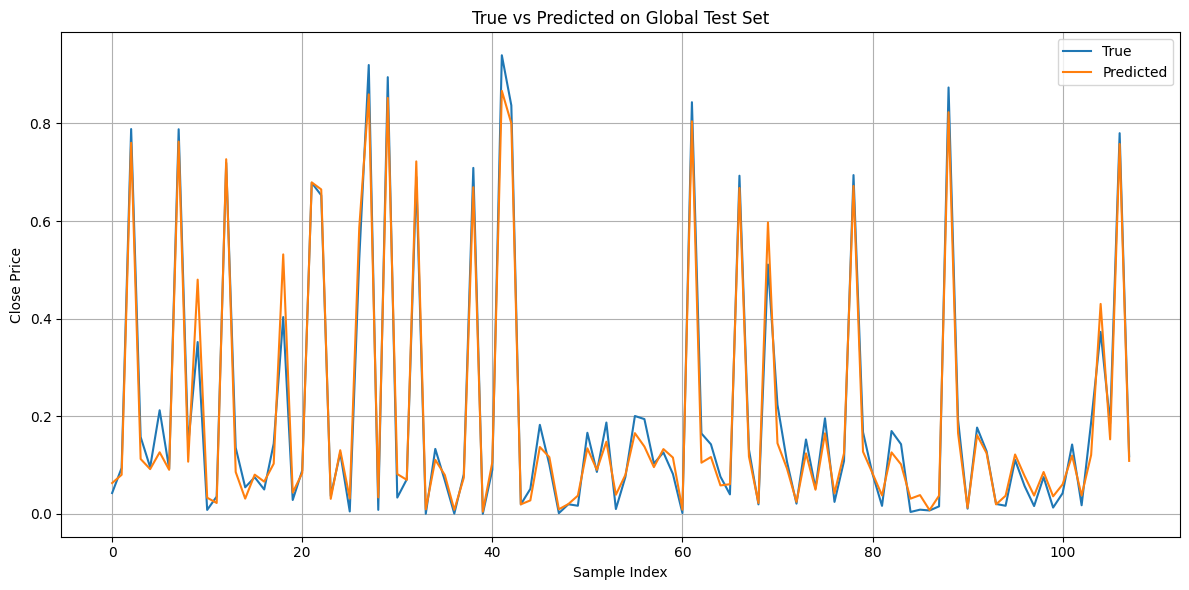

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define BiLSTM model creation
def create_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.2),
        Bidirectional(LSTM(32)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# MAML-style inner loop adaptation
def inner_loop_adaptation(model, X, y, lr=0.01, steps=1):
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    y = tf.convert_to_tensor(y, dtype=tf.float32)
    adapted_vars = [tf.Variable(w) for w in model.get_weights()]

    for _ in range(steps):
        with tf.GradientTape() as tape:
            model.set_weights([var.numpy() for var in adapted_vars])
            preds = model(X)
            loss = tf.keras.losses.mse(y, preds)
        grads = tape.gradient(loss, adapted_vars)
        for var, grad in zip(adapted_vars, grads):
            if grad is not None:
                var.assign_sub(lr * grad)
    return [var.numpy() for var in adapted_vars]

# Federated-MAML Training Loop
def federated_maml(global_model, client_data, inner_lr=0.01, inner_steps=1, meta_lr=0.001, meta_epochs=100):
    optimizer = tf.keras.optimizers.Adam(meta_lr)

    for epoch in range(meta_epochs):
        print(f"\n--- Federated MAML Epoch {epoch + 1} ---")
        global_vars = global_model.trainable_variables
        grads_sum = [tf.zeros_like(w) for w in global_vars]

        for X_client, y_client in client_data:
            X_client = np.array(X_client)
            y_client = np.array(y_client)

            model_copy = tf.keras.models.clone_model(global_model)
            model_copy.set_weights(global_model.get_weights())

            adapted_weights = inner_loop_adaptation(model_copy, X_client, y_client, inner_lr, inner_steps)
            model_copy.set_weights(adapted_weights)

            with tf.GradientTape() as tape:
                X_tf = tf.convert_to_tensor(X_client, dtype=tf.float32)
                y_tf = tf.convert_to_tensor(y_client, dtype=tf.float32)
                preds = model_copy(X_tf)
                loss = tf.keras.losses.mse(y_tf, preds)
            grads = tape.gradient(loss, model_copy.trainable_variables)
            grads_sum = [g_sum + g for g_sum, g in zip(grads_sum, grads)]

        avg_grads = [g / len(client_data) for g in grads_sum]
        if len(global_vars) == len(avg_grads):
            optimizer.apply_gradients(zip(avg_grads, global_vars))
        else:
            print("Warning: Mismatch between global_vars and avg_grads length.")

    return global_model

# Assuming df is preloaded and preprocessed DataFrame
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'neutral', 'positive', 'negative',
                'Company Name_GI', 'Company Name_MFL', 'Company Name_Pc', 'Company Name_REX', 'Company Name_TBZ']
target_col = 'Close'

X = df[feature_cols].drop(columns=[target_col], errors='ignore').values
y = df[target_col].values

n_timesteps = 1
n_features = X.shape[1]
X = X.reshape((X.shape[0], n_timesteps, n_features))

client_names = [col for col in df.columns if col.startswith('Company Name_')]
client_data = []

for client_col in client_names:
    client_df = df[df[client_col] == 1].copy()
    if not client_df.empty:
        X_client = client_df[feature_cols].drop(columns=[target_col], errors='ignore').values
        y_client = client_df[target_col].values
        X_client = X_client.reshape((X_client.shape[0], n_timesteps, n_features))
        client_data.append((X_client, y_client))
    else:
        print(f"Warning: No data found for client column '{client_col}'.")

all_X = np.concatenate([x for x, y in client_data])
all_y = np.concatenate([y for x, y in client_data])

if all_X.shape[0] > 1:
    X_meta_train, X_test, y_meta_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=42)
else:
    X_test = all_X
    y_test = all_y

client_data_for_maml = client_data

input_shape = (X.shape[1], X.shape[2]) if X.shape[0] > 0 else (1, 1)

if X_test.shape[0] > 0:
    global_model = create_model(input_shape)
    global_model = federated_maml(global_model, client_data_for_maml)
    loss = global_model.evaluate(X_test, y_test, verbose=0)
    print(f"Final Federated-MAML Global Model Test MSE: {loss:.4f}")

    # Predict and plot
    y_pred = global_model.predict(X_test)
    y_true_flat = y_test.flatten()
    y_pred_flat = y_pred.flatten()

    plt.figure(figsize=(12, 6))
    plt.plot(y_true_flat, label='True')
    plt.plot(y_pred_flat, label='Predicted')
    plt.title("True vs Predicted on Global Test Set")
    plt.xlabel("Sample Index")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Warning: X_test or y_test are not defined or empty. Skipping global model evaluation.")

In [13]:
df=pd.read_csv('/content/final_dataset_with_sentiment.csv')
df

,Company Name,Date,Close,Open,High,Low,Change %,Price Range,Price Movement,Body Ratio,Candle Type,Volume Change,Volume Per Price Change,News,Volume,neutral,positive,negative,sentiment_label
0,Pc,2015-04-01,17.11,15.85,18.44,15.28,0.08,3.16,1.26,0.40,1.0,NaN,"57,166,666.67",PC Jewellers expanded retail stores in key cit...,72030000.0,7.176002e-09,1.000000,8.978274e-10,Positive
1,Pc,2015-05-01,18.80,17.11,19.00,15.85,0.10,3.15,1.69,0.54,1.0,-7720000.0,"38,053,254.44",Strong festival season sales boosted revenue.,64310000.0,8.497756e-09,1.000000,1.190868e-08,Positive
2,Pc,2015-06-01,19.21,18.95,20.40,15.90,0.02,4.50,0.26,0.06,1.0,35580000.0,"384,192,307.69",Delay in quarterly results raised investor con...,99890000.0,2.679705e-07,0.000003,9.999963e-01,Negative
3,Pc,2015-07-01,23.00,19.20,23.35,19.01,0.20,4.34,3.80,0.88,1.0,-600000.0,"26,128,947.37",Increased store footfall and promotional offer...,99290000.0,2.470665e-08,1.000000,2.993213e-08,Positive
4,Pc,2015-08-01,19.96,22.61,24.67,15.15,-0.13,9.52,-2.65,-0.28,0.0,100340000.0,"75,332,075.47",Weak global gold prices impacted export earnin...,199630000.0,5.076001e-07,0.000005,9.999945e-01,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,MFL,2023-11-01,164.40,136.00,166.65,134.40,0.20,32.25,28.40,0.88,1.0,140520000.0,"9,752,112.68",Announces plans to modernize physical branches...,276960000.0,9.970577e-01,0.002939,3.634907e-06,Neutral
535,MFL,2023-12-01,172.00,165.10,177.55,158.25,0.05,19.30,6.90,0.36,1.0,-76730000.0,"29,018,840.58",Reports gradual rise in gold loan portfolio ah...,200230000.0,8.868055e-07,0.999999,3.634408e-08,Positive
536,MFL,2024-01-01,184.75,172.10,188.20,163.35,0.07,24.85,12.65,0.51,1.0,5830000.0,"16,289,328.06",Ends calendar year with stable margins and imp...,206060000.0,4.438657e-09,1.000000,1.624528e-09,Positive
537,MFL,2024-02-01,176.20,176.50,192.50,170.05,-0.05,22.45,-0.30,0.01,0.0,-31180000.0,"582,933,333.33",Announces strategic tie-up with fintech startu...,174880000.0,2.667556e-01,0.733242,1.995500e-06,Positive
